<h1 style='color:orange; font-weight:bold; text-align:center'>Non-Negative Matrix Factorization</h1>

## **5 Non-Negative Matrix Factorization**
Recap previous section

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **5.1 Data Preparation**

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import time
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from matplotlib.font_manager import FontProperties
from gensim.corpora import Dictionary
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [206]:
# # Load the dataset
# df = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [207]:
# load dataset from GDrive
df = pd.read_csv('/content/drive/MyDrive/DATA-SCIENCE/TOPIC-MODELING/data/review_gopay_newest_sort.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123253 entries, 0 to 123252
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   userName              123253 non-null  object
 1   content               123253 non-null  object
 2   score                 123253 non-null  int64 
 3   thumbsUpCount         123253 non-null  int64 
 4   reviewCreatedVersion  107325 non-null  object
 5   at                    123253 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.6+ MB


In [208]:
# prepare stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh', 'ya', 'kan', 'nih', 'dah', 'nya'}
stop_words.update(custom_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [209]:
# find which words are in the stop_words set
negations = {'tidak', 'ga', 'gk', 'tdk', 'g'}
words_in_stopwords = negations.intersection(stop_words)
words_not_in_stopwords = negations.difference(stop_words)

# print the result
print("Words in stop_words:", words_in_stopwords)
print("Words not in stop_words:", words_not_in_stopwords)

Words in stop_words: {'tidak'}
Words not in stop_words: {'ga', 'tdk', 'gk', 'g'}


In [210]:
# define synonym dictionary
synonym_dict = {
    'apk': 'aplikasi', 'app': 'aplikasi', 'apps': 'aplikasi', 'aplikasinya': 'aplikasi',
    'oke': 'ok', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak',
    'g':'tidak', 'tf': 'transfer', 'bgt': 'banget', 'bngt': 'banget', 'yg': 'yang'
}

# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

# function to split the clitic '-nya'
def split_clitic(word):
    if word.endswith('nya') and len(word) > 3:                          # check for words ending with '-nya'
        return [word[:-3], 'nya']                                       # split into base word and 'nya'
    return [word]

In [211]:
# preprocess function to clean text
def clean_text(text):
    if isinstance(text, str):                                                 # check if the input is a string
        text = text.lower()                                                   # convert to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)                   # remove URLs
        text = re.sub(r'\d+', '', text)                                       # remove numbers
        text = re.sub(r'_+', ' ', text)                                       # remove underscores
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)                            # remove non-ASCII characters
        text = re.sub(r'\W+', ' ', text)                                      # remove punctuation
        text = re.sub(r'\s+', ' ', text)                                      # replace multiple spaces with a single space
        tokens = text.split()                                                 # tokenize text

        # normalize elongated words, replace synonyms, and remove stopwords
        tokens = [normalize_repeated_chars(word) for word in tokens]          # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]            # replace with synonym if it exists
        tokens = [token for word in tokens for token in split_clitic(word)]   # handle clitic splitting
        tokens = [word for word in tokens if word not in stop_words]          # remove stopwords

        return tokens
    return ''

# apply the updated preprocessing function
df['cleaned_content'] = df['content'].apply(clean_text)

In [212]:
# check preprocessing quality
df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,cleaned_content
0,Pengguna Google,Mantap,5,0,1.24.1,2024-07-07 16:58:06,[mantap]
1,Pengguna Google,Bagus dan mudah digunakan,5,0,1.24.1,2024-07-07 16:57:08,"[bagus, mudah]"
2,Pengguna Google,Good,5,0,1.24.1,2024-07-07 16:52:38,[good]
3,Pengguna Google,Sangat membantu orang menengah mantap semoga sukses terus gopay,5,0,1.24.1,2024-07-07 16:52:36,"[membantu, orang, menengah, mantap, semoga, sukses, gopay]"
4,Pengguna Google,Ga ribet .. Sukaaaa,5,0,1.24.1,2024-07-07 16:52:09,"[ribet, suka]"


In [213]:
# use TF-IDF for vectorizing texts
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)  # use preprocessed tokens directly
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

In [214]:
# prepare dataset
feature_names = vectorizer.get_feature_names_out()
dense_tfidf = tfidf_matrix.todense()
df_tfidf = pd.DataFrame(dense_tfidf, columns=feature_names)

# display the first few rows to see the output
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
display(df_tfidf.head())

TF-IDF Matrix shape: (123253, 23777)


,a,aa,aab,aad,aada,aadana,aah,aahaha,aahh,aaja,...,zonkk,zoonk,zoos,zos,zsip,zsuka,zulu,zuper,zuzur,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
# create dict and a corpus
dictionary = Dictionary(df['cleaned_content'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_content']]

In [216]:
# view dictionary (word to ID mapping)
print(f'The content of dictionary: \n{list(dictionary.token2id.items())[:5]}\n')

# print top documents in corpus (+ freq)
print('The content of corpus:')
for i in range(5):
    doc = corpus[i]
    decoded_doc = [(dictionary[id], freq) for id, freq in doc]
    print(f"> Document {i+1}: {decoded_doc}")

The content of dictionary: 
[('mantap', 0), ('bagus', 1), ('mudah', 2), ('good', 3), ('gopay', 4)]

The content of corpus:
> Document 1: [('mantap', 1)]
> Document 2: [('bagus', 1), ('mudah', 1)]
> Document 3: [('good', 1)]
> Document 4: [('mantap', 1), ('gopay', 1), ('membantu', 1), ('menengah', 1), ('orang', 1), ('semoga', 1), ('sukses', 1)]
> Document 5: [('ribet', 1), ('suka', 1)]


### **5.2 Brief Introduction to NMF**
NMF is a topic model algorithm which breaks down or factorizes a matrix into smaller parts (non-negative numbers). For an illustration, let us take a look at the following example.
```
Doc1: [2, 0, 1, 3] # Doc1 contains 2 instances of w1, 1 instance w3, and 3 instances of w4
Doc2: [1, 2, 0, 0] # Doc2 contains 1 instance of w1, 2 instances of w2
```
Factorization is done to break down the matrix into smaller ones. One is topic matrix, consisting of what words are important for each topic. The other one is a document matrix, telling how much each doc contains each topic.

### **5.3 Grid Search for Ideal Topic Number**

In [217]:
# define range for number of topics
topics_range = range(2, 11)
coherence_scores = []
timing_info = []

# train NMF model and calculate coherence scores
for num_topics in topics_range:
    # fit the NMF model
    start_time = time.time()
    print(f'Training model with {num_topics} topics...')
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=1000)
    nmf_model.fit(tfidf_matrix)

    # get topics and corresponding words
    topic_words = []
    feature_names = vectorizer.get_feature_names_out()

    for topic in nmf_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # top 10 words for the topic
        topic_words.append(top_words)

    # calculate coherence score
    coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    end_time = time.time()
    elapsed_time = end_time - start_time
    timing_info.append(elapsed_time)
    print(f'> Coherence score: {coherence_score:.4f}, TT: {elapsed_time:.2f} seconds')

Training model with 2 topics...
> Coherence score: 0.4299, TT: 6.14 seconds
Training model with 3 topics...
> Coherence score: 0.4647, TT: 7.21 seconds
Training model with 4 topics...
> Coherence score: 0.5028, TT: 5.47 seconds
Training model with 5 topics...
> Coherence score: 0.5170, TT: 7.42 seconds
Training model with 6 topics...
> Coherence score: 0.4428, TT: 6.39 seconds
Training model with 7 topics...
> Coherence score: 0.4659, TT: 16.37 seconds
Training model with 8 topics...
> Coherence score: 0.4793, TT: 15.92 seconds
Training model with 9 topics...
> Coherence score: 0.4741, TT: 16.65 seconds
Training model with 10 topics...
> Coherence score: 0.4726, TT: 14.84 seconds


In [218]:
# choose optimal n of topic
mean_cs = np.mean(coherence_scores)
sd_cs = np.std(coherence_scores)
mean_tt = round(np.mean(timing_info), 2)
sd_tt = round(np.std(timing_info), 2)
optimal_num_topics = topics_range[np.argmax(coherence_scores)]

# print results
print(f'Optimal num of topics: {optimal_num_topics} with coherence score: {coherence_scores[optimal_num_topics - 2]:.4f}')
print(f'> Mean of coherence scores: {mean_cs:.4f} ± {sd_cs:.4f}')
print(f'> Total TT: {sum(timing_info):.2f} seconds (mean: {mean_tt} ± {sd_tt} seconds)')

Optimal num of topics: 5 with coherence score: 0.5170
> Mean of coherence scores: 0.4721 ± 0.0253
> Total TT: 96.43 seconds (mean: 10.71 ± 4.73 seconds)


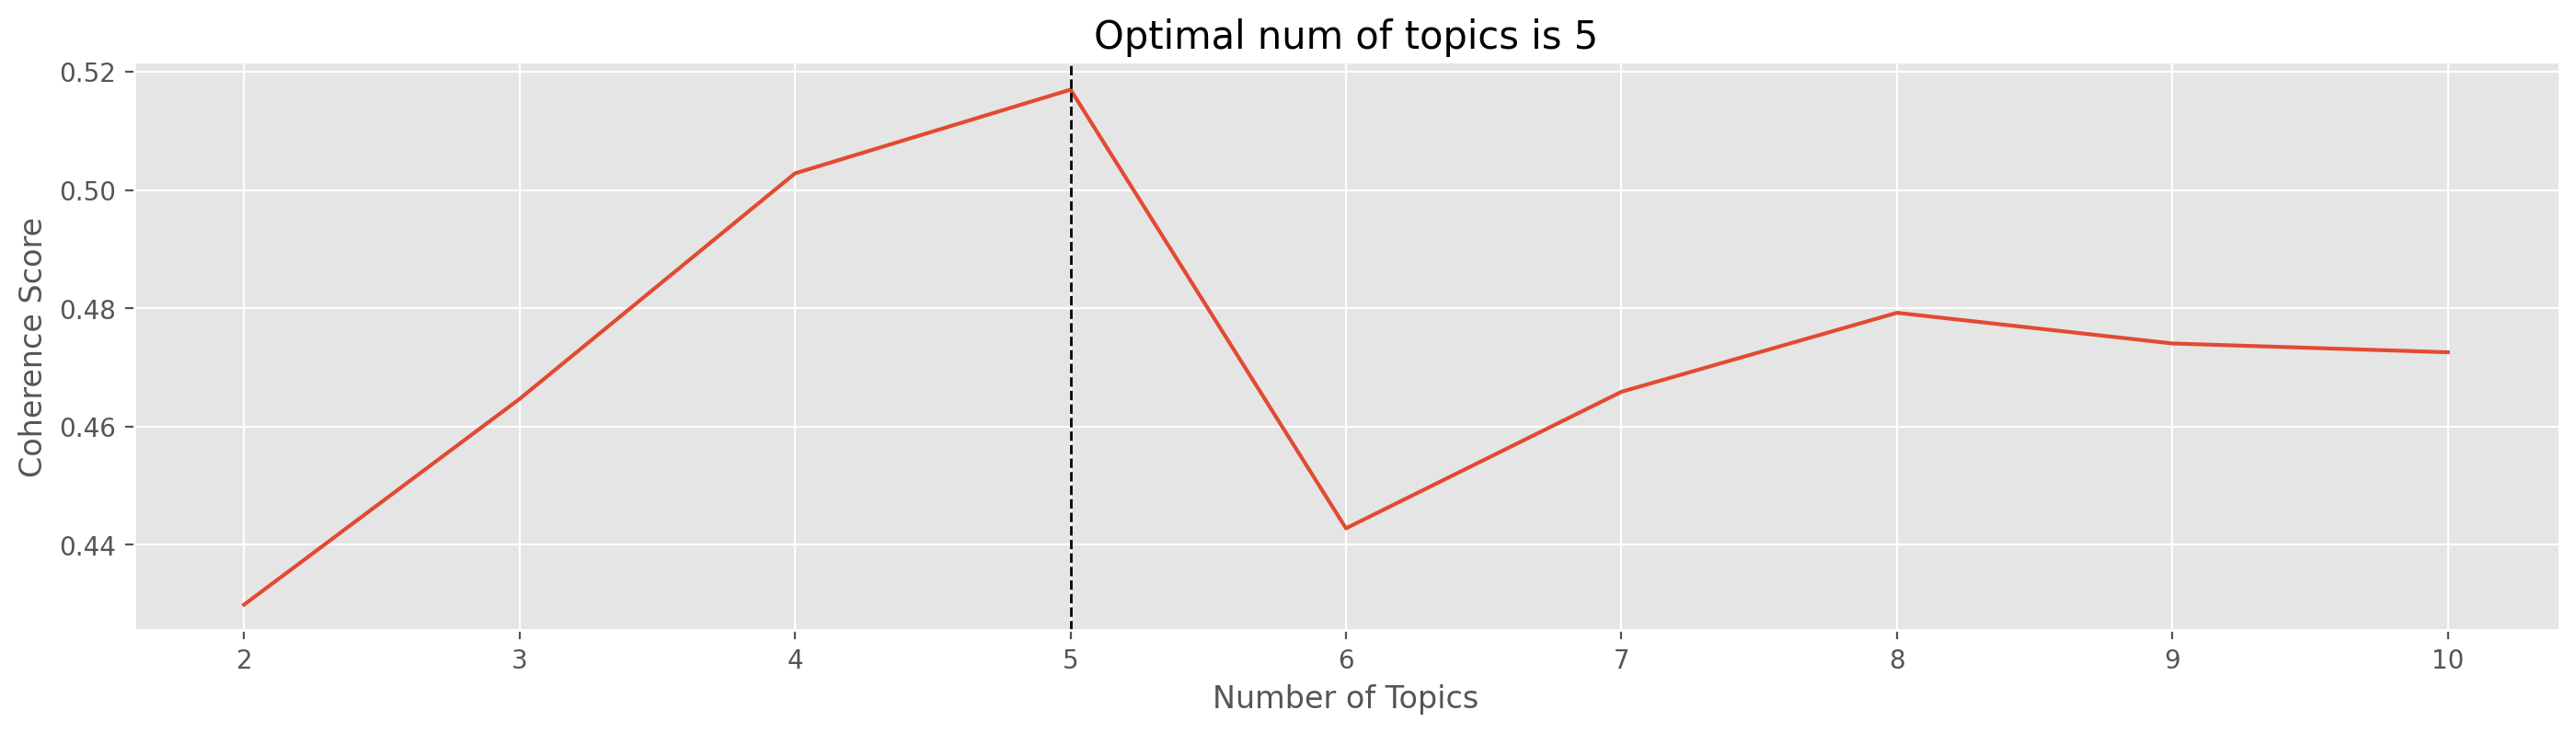

In [219]:
# plot coherence scores
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(topics_range, coherence_scores)
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(range(2, 11, 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal num of topics is {optimal_num_topics}', size=15)
plt.show()

### **5.4 NMF Model Training**

In [220]:
# Train NMF model with the optimal number of topics
nmf_model = NMF(n_components=optimal_num_topics, random_state=42, max_iter=1000)
nmf_model.fit(tfidf_matrix)

NMF(max_iter=1000, n_components=5, random_state=42)

In [221]:
# print topics (10 words per topic)
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: gratis, banget, transaksi, pokok, transfer, cepat, mudah, aplikasi, gopay, mantap
Topic 1: suka, aman, transfer, transaksi, gopay, cepat, mudah, banget, aplikasi, bagus
Topic 2: transaksi, transfer, pokok, cepat, mudah, sip, aplikasi, gopay, banget, ok
Topic 3: pembayaran, terimakasih, transfer, cepat, banget, transaksi, gopay, mudah, aplikasi, membantu
Topic 4: transfer, transaksi, keren, banget, mudah, very, gopay, job, aplikasi, good


In [222]:
topic_words = []
feature_names = vectorizer.get_feature_names_out()

for topic in nmf_model.components_:
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # top 10 words for the topic
    topic_words.append(top_words)

In [223]:
# topic_words = nmf_model.components_
coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'],
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence score: {coherence_score:.4f}')

Coherence score: 0.5170


### **5.5 Hyperparameter Tuning**

In [224]:
# define hyperparameter grid
param_grid = {
    'alpha_W': [0, 0.001, 0.01, 0.1],   # regularization strength
    'max_iter': [500, 1000]             # number of iterations
}

# init variables to track the best coherence score and parameters
best_coherence = -1
best_params = {}

# generate grid of parameters
grid = ParameterGrid(param_grid)

In [225]:
# loop through each combination of parameters
for params in grid:
    start_time = time.time()

    # train the NMF model
    nmf_model = NMF(n_components=optimal_num_topics, alpha_W=params['alpha_W'],
                    max_iter=params['max_iter'], random_state=42)
    nmf_model.fit(tfidf_matrix)

    # get topics
    topic_words = []
    feature_names = vectorizer.get_feature_names_out()
    for topic in nmf_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        topic_words.append(top_words)

    # calculate coherence score
    coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'],
                                     dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Params: {params}, coherence score: {coherence_score:.4f}, time: {elapsed_time:.2f} seconds")

    # update best score and parameters
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_params = params

print(f"Best coherence score: {best_coherence:.4f} with params: {best_params}")

Params: {'alpha_W': 0, 'max_iter': 500}, coherence score: 0.5170, time: 5.67 seconds
Params: {'alpha_W': 0, 'max_iter': 1000}, coherence score: 0.5170, time: 6.26 seconds
Params: {'alpha_W': 0.001, 'max_iter': 500}, coherence score: 0.3940, time: 6.98 seconds
Params: {'alpha_W': 0.001, 'max_iter': 1000}, coherence score: 0.3940, time: 5.60 seconds
Params: {'alpha_W': 0.01, 'max_iter': 500}, coherence score: 0.3367, time: 7.31 seconds
Params: {'alpha_W': 0.01, 'max_iter': 1000}, coherence score: 0.3367, time: 6.41 seconds
Params: {'alpha_W': 0.1, 'max_iter': 500}, coherence score: 0.3194, time: 6.76 seconds
Params: {'alpha_W': 0.1, 'max_iter': 1000}, coherence score: 0.3194, time: 5.48 seconds
Best coherence score: 0.5170 with params: {'alpha_W': 0, 'max_iter': 500}


In [226]:
# train NMF model with optimal number of topics
tuned_nmf_model = NMF(n_components=optimal_num_topics, alpha_W=0,
                      random_state=42, max_iter=500)
tuned_nmf_model.fit(tfidf_matrix)

NMF(alpha_W=0, max_iter=500, n_components=5, random_state=42)

In [227]:
# extract top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = []

for topic in tuned_nmf_model.components_:
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words for each topic
    topic_words.append(top_words)

# create coherence model using NMF topics
tuned_coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'],
                                       dictionary=dictionary, coherence='c_v')

# calculate and print coherence score
tuned_coherence_score = tuned_coherence_model.get_coherence()
print(f'Coherence score: {tuned_coherence_score:.4f}')

Coherence score: 0.5170


### **5.6 Evaluation and Explanation**

#### **5.6.1 Model Selection**

#### **5.6.2 Topic Extraction**

In [228]:
# print the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(tuned_nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: gratis, banget, transaksi, pokok, transfer, cepat, mudah, aplikasi, gopay, mantap
Topic 1: suka, aman, transfer, transaksi, gopay, cepat, mudah, banget, aplikasi, bagus
Topic 2: transaksi, transfer, pokok, cepat, mudah, sip, aplikasi, gopay, banget, ok
Topic 3: pembayaran, terimakasih, transfer, cepat, banget, transaksi, gopay, mudah, aplikasi, membantu
Topic 4: transfer, transaksi, keren, banget, mudah, very, gopay, job, aplikasi, good


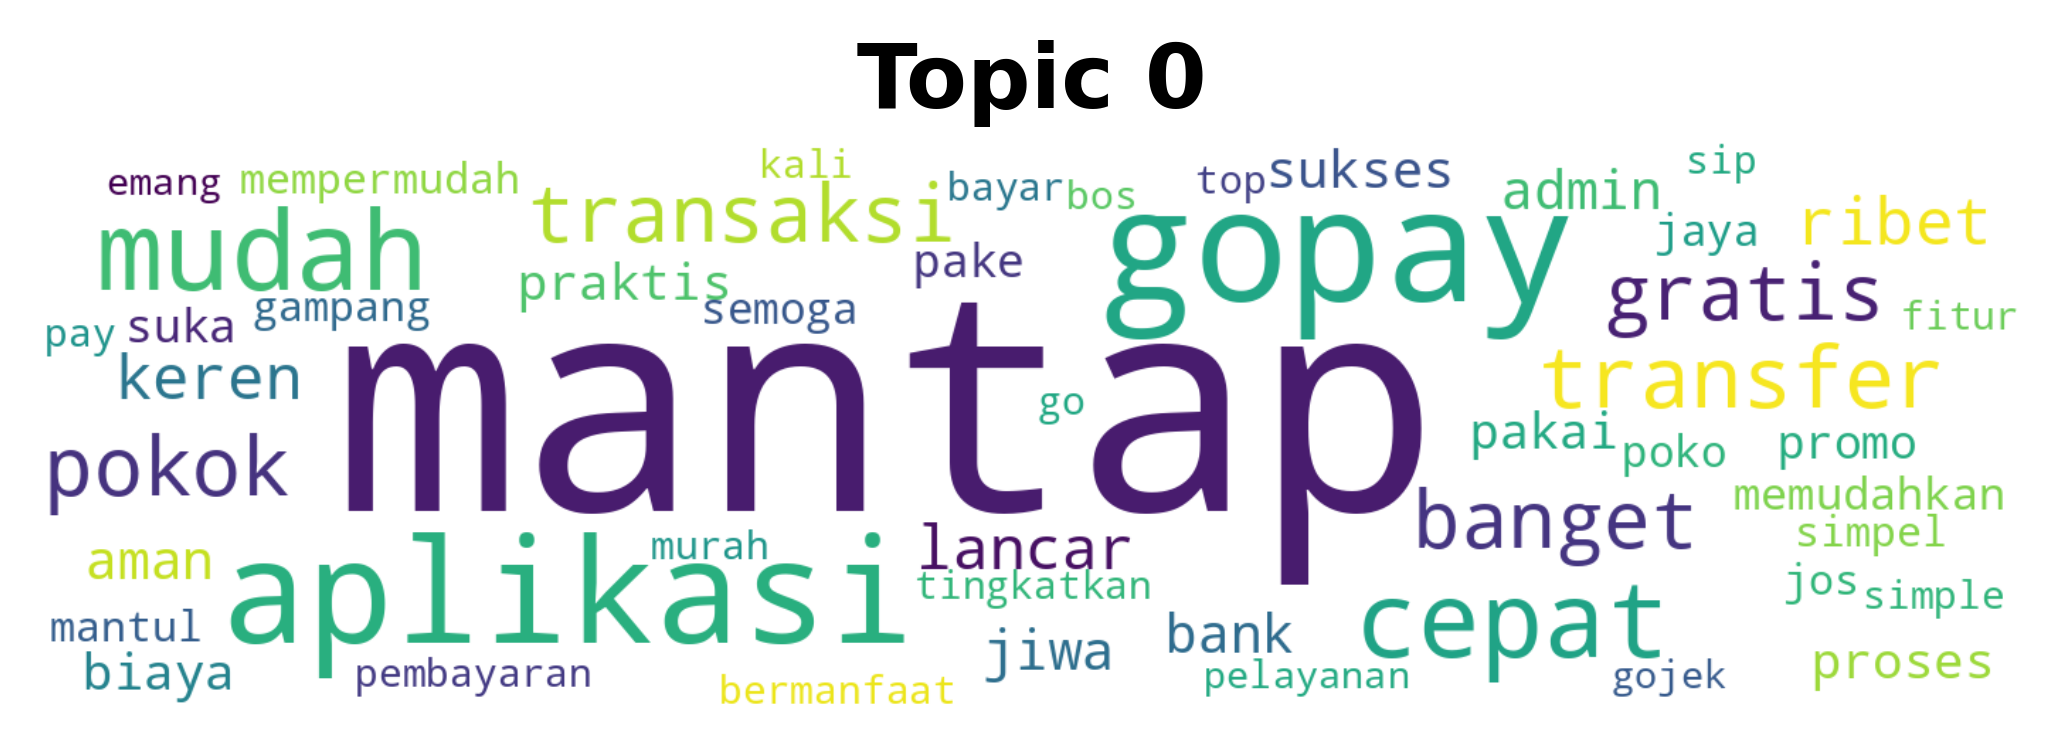

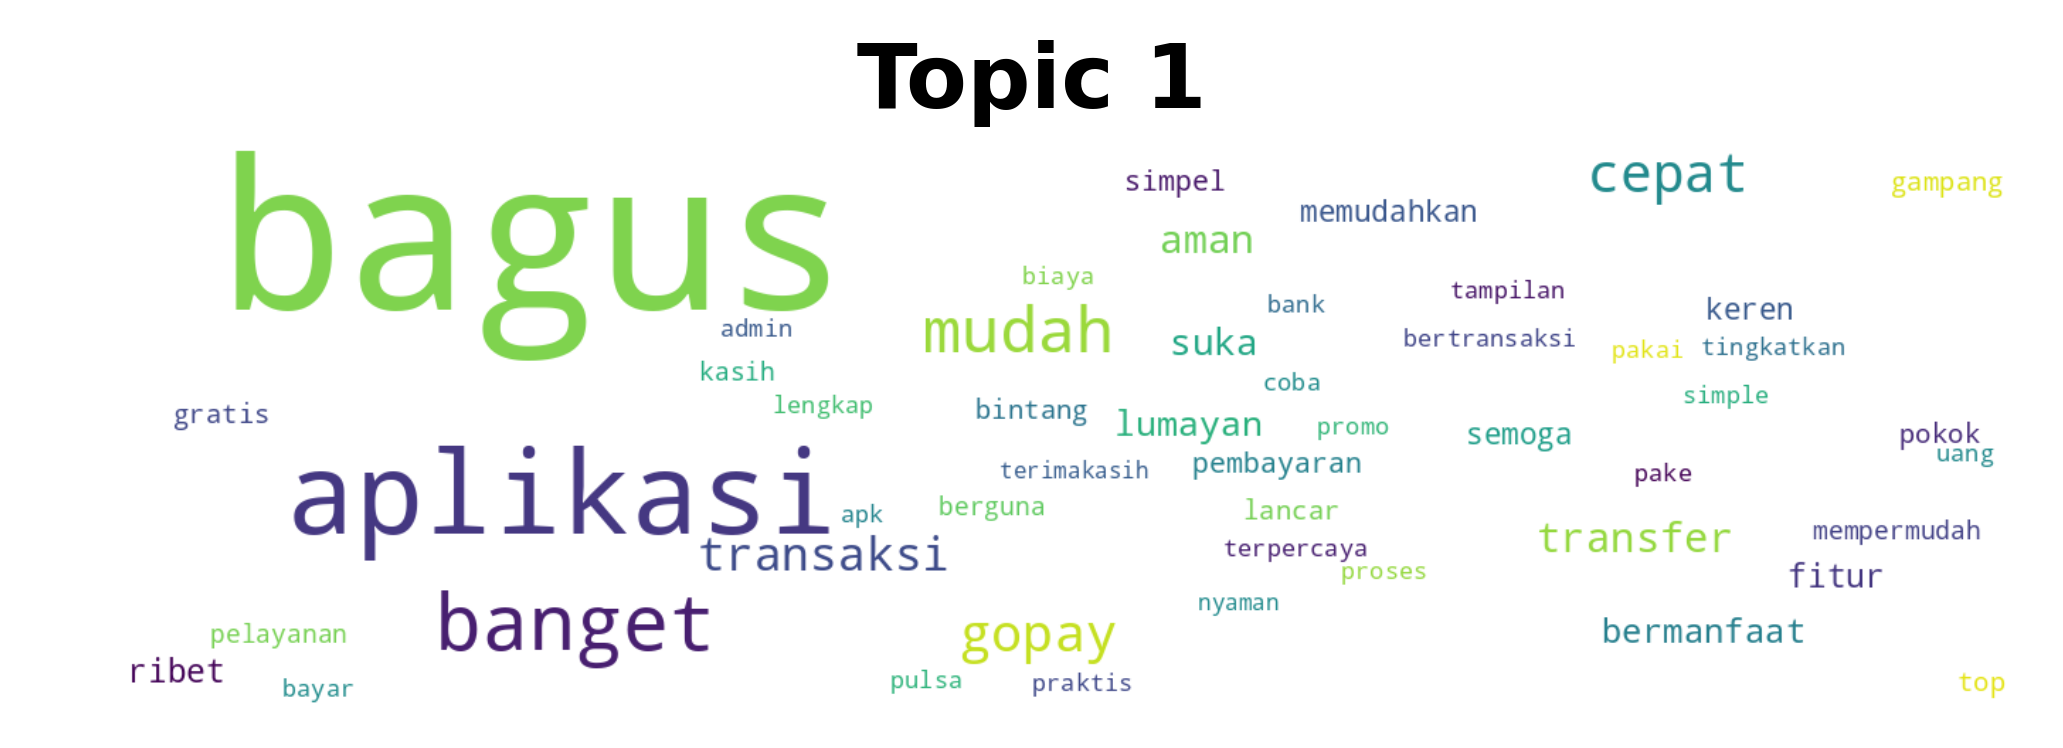

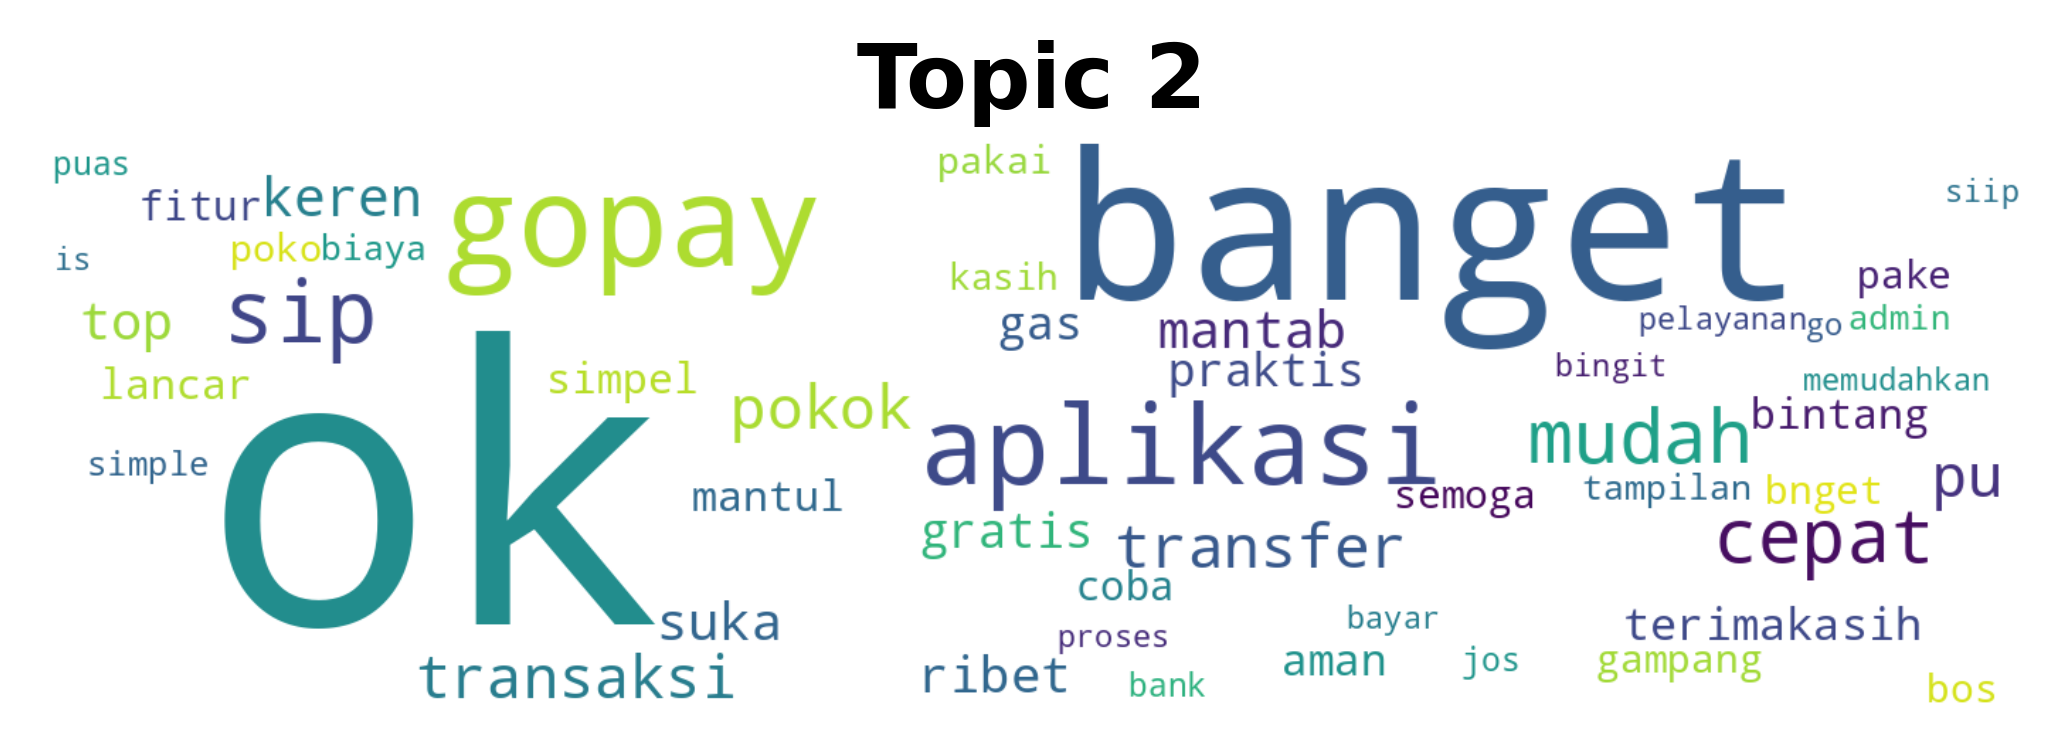

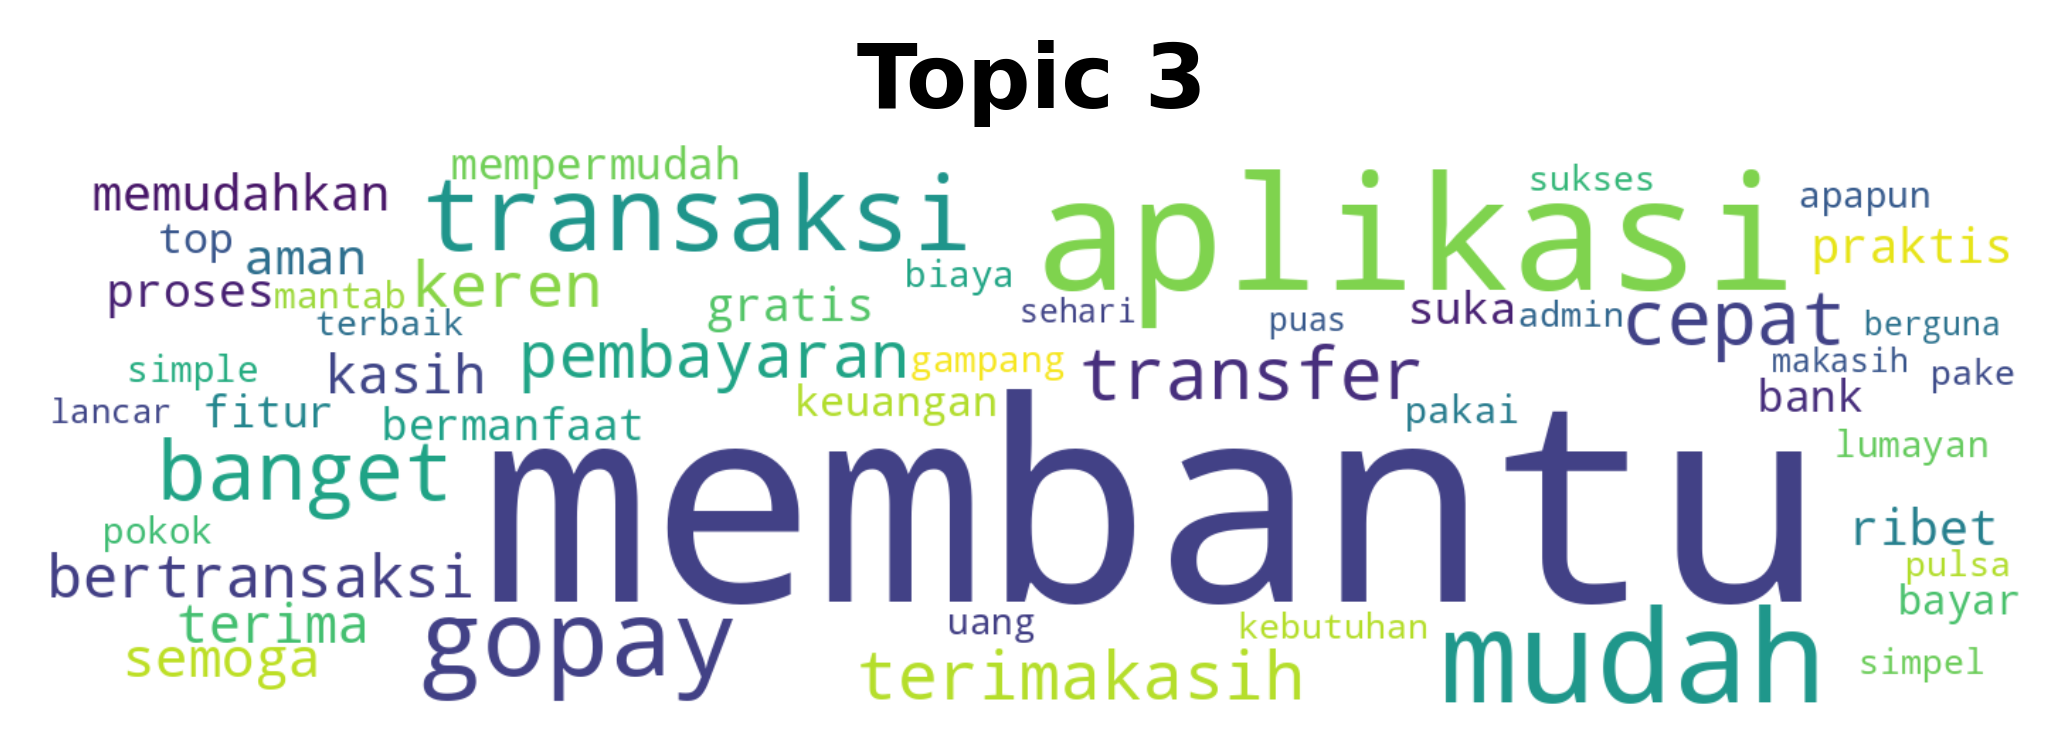

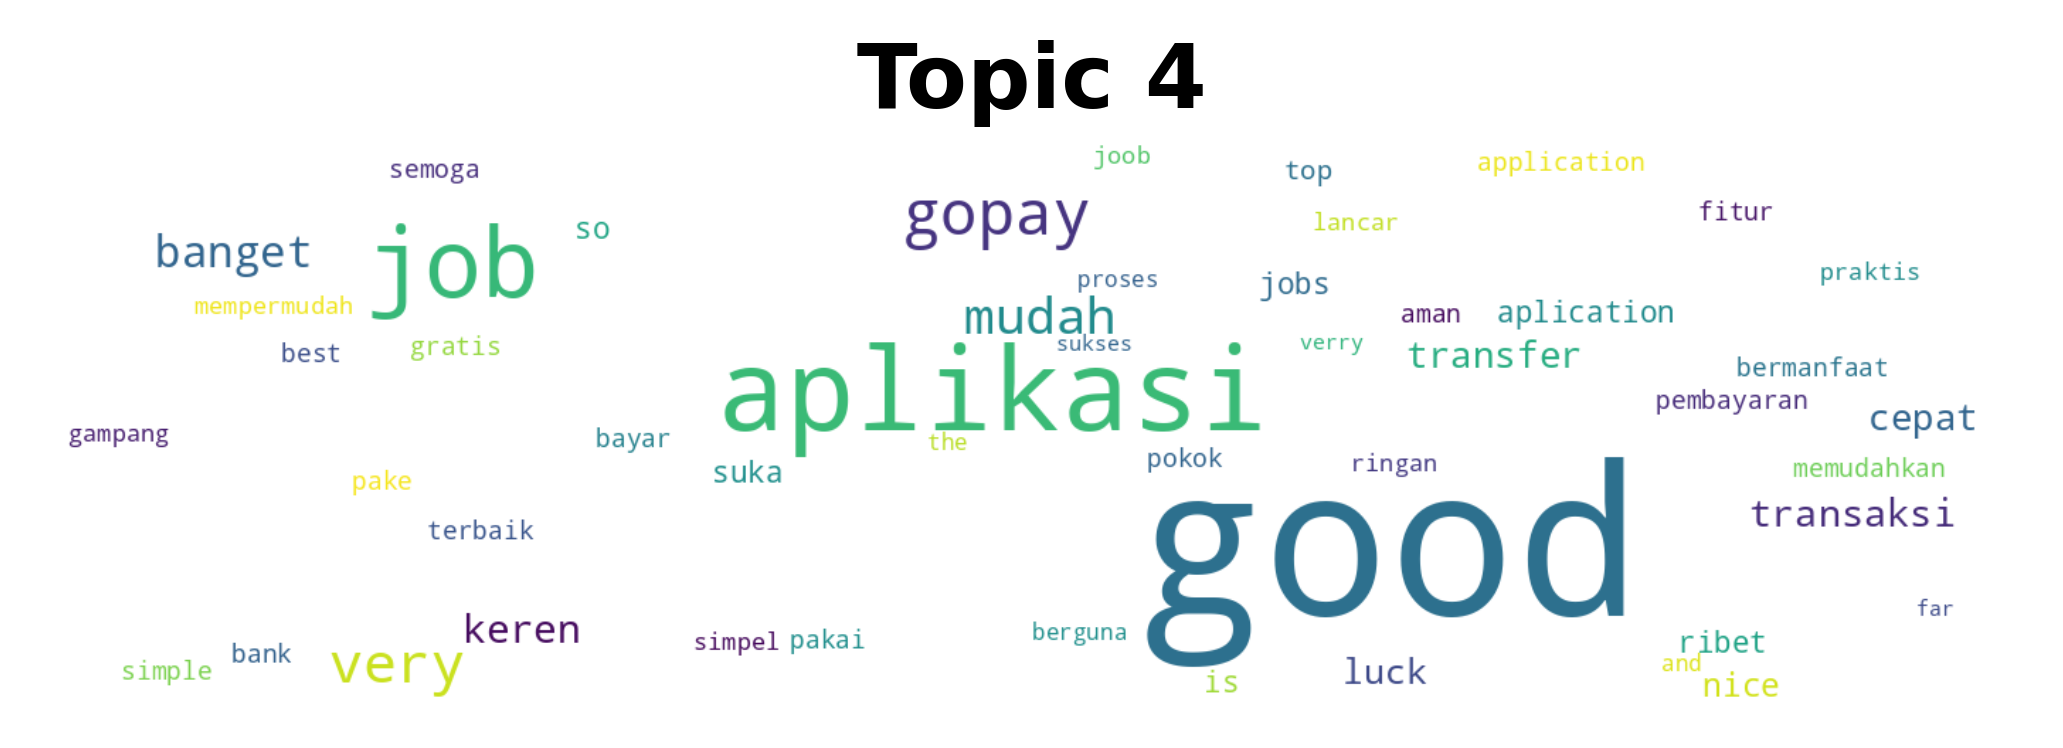

In [229]:
# generate word clouds for each topic
feature_names = vectorizer.get_feature_names_out()

for idx, topic in enumerate(tuned_nmf_model.components_):
    plt.figure(dpi=400)
    # create dict of words and their weights
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-50:]}
    # generate word cloud
    wordcloud = WordCloud(width=1400, height=400, background_color='white', prefer_horizontal=1.0).generate_from_frequencies(word_freq)
    # visualize word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx}', size=16, weight='bold')
    plt.show()

In [230]:
pd.options.display.max_colwidth=None

# n of top words to display per topic
n_top_words = 10

# extract topics and word distributions
topics_data = []
for topic_idx, topic in enumerate(tuned_nmf_model.components_):
    top_words = [(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
    formatted_topic = ', '.join([f"({word}, {weight:.2f})" for word, weight in top_words])
    topics_data.append((topic_idx, formatted_topic))

# create df
topics_df = pd.DataFrame(topics_data, columns=['n_topic', 'top_words'])
pd.options.display.max_colwidth = None
display(topics_df)

,n_topic,top_words
0,0,"(mantap, 9.83), (gopay, 0.32), (aplikasi, 0.27), (mudah, 0.14), (cepat, 0.12), (transfer, 0.08), (pokok, 0.07), (transaksi, 0.07), (banget, 0.07), (gratis, 0.06)"
1,1,"(bagus, 9.34), (aplikasi, 0.93), (banget, 0.33), (mudah, 0.21), (cepat, 0.14), (gopay, 0.13), (transaksi, 0.10), (transfer, 0.08), (aman, 0.07), (suka, 0.06)"
2,2,"(ok, 9.01), (banget, 0.55), (gopay, 0.12), (aplikasi, 0.09), (sip, 0.05), (mudah, 0.04), (cepat, 0.04), (pokok, 0.03), (transfer, 0.03), (transaksi, 0.02)"
3,3,"(membantu, 7.94), (aplikasi, 1.10), (mudah, 0.69), (gopay, 0.45), (transaksi, 0.42), (banget, 0.25), (cepat, 0.21), (transfer, 0.19), (terimakasih, 0.17), (pembayaran, 0.16)"
4,4,"(good, 7.57), (aplikasi, 0.71), (job, 0.48), (gopay, 0.14), (very, 0.11), (mudah, 0.09), (banget, 0.07), (keren, 0.05), (transaksi, 0.05), (transfer, 0.05)"


**Note**
- **Topic 0**: User satisfaction and experience
- **Topic 1**: App quality and usability
- **Topic 2**: Simple positive feedback
- **Topic 3**: App helpfulness and usability
- **Topic 4**: Positive feedback

#### **5.6.3 Assign the Most Probable Topic to Each Document**

In [231]:
# init topics with default -1
df['topic'] = -1

# get document-topic distribution matrix
doc_topic_dist = tuned_nmf_model.transform(tfidf_matrix)  # shape: (num_documents, num_topics)

# loop over each document and assign most probable topic
for i, topic_probs in enumerate(doc_topic_dist):
    if topic_probs.any():                           # check if any non-zero probabilities
        most_probable_topic = topic_probs.argmax()  # get topic with highest probability
        df.at[i, 'topic'] = most_probable_topic

display(df.head())

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,cleaned_content,topic
0,Pengguna Google,Mantap,5,0,1.24.1,2024-07-07 16:58:06,[mantap],0
1,Pengguna Google,Bagus dan mudah digunakan,5,0,1.24.1,2024-07-07 16:57:08,"[bagus, mudah]",1
2,Pengguna Google,Good,5,0,1.24.1,2024-07-07 16:52:38,[good],4
3,Pengguna Google,Sangat membantu orang menengah mantap semoga sukses terus gopay,5,0,1.24.1,2024-07-07 16:52:36,"[membantu, orang, menengah, mantap, semoga, sukses, gopay]",3
4,Pengguna Google,Ga ribet .. Sukaaaa,5,0,1.24.1,2024-07-07 16:52:09,"[ribet, suka]",3


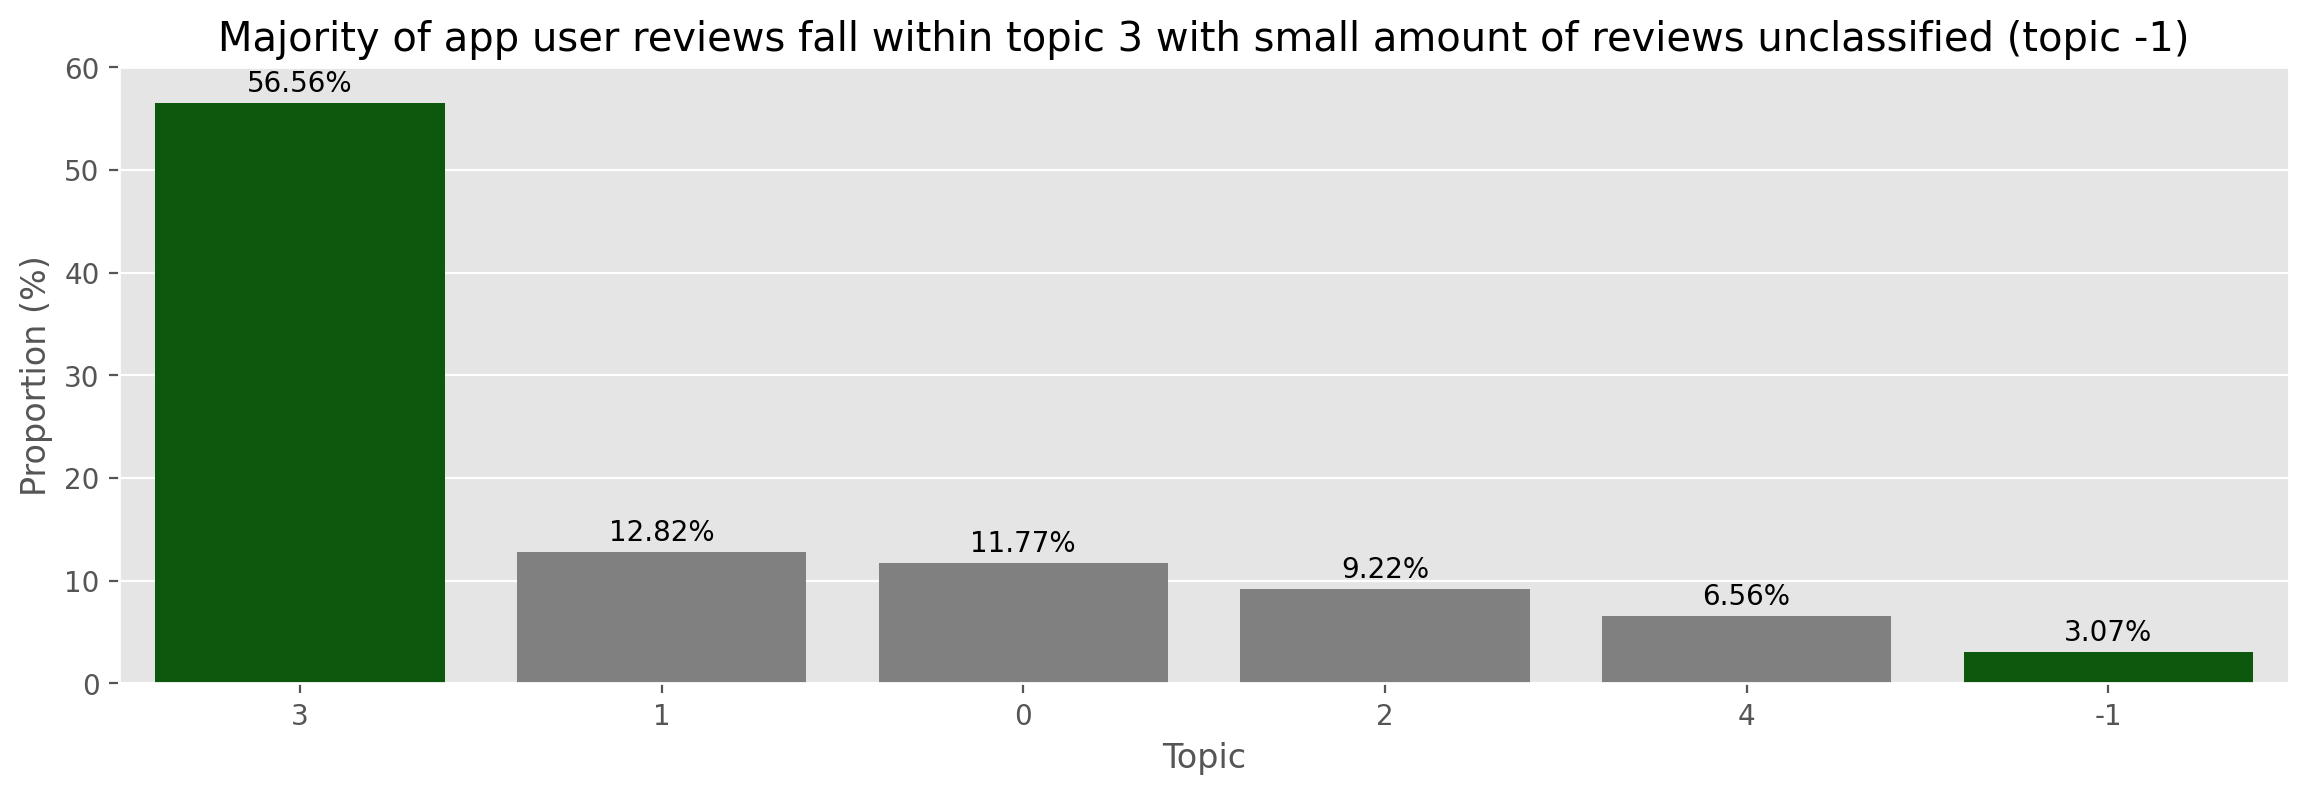

In [232]:
# prepare data
topic_proportion = (df['topic'].value_counts(normalize=True)*100).reset_index().round(2)
topic_proportion['topic'] = topic_proportion['topic'].astype(str)
topic_proportion = topic_proportion.sort_values(by='proportion', ascending=False)

# set figure size
plt.figure(figsize=(14, 4), dpi=200)

# highlight topic 1 and 4
highlight_colors = ['darkgreen' if topic in ['3', '-1'] else 'grey' for topic in topic_proportion['topic']]

# make bar chart
sns.barplot(y='proportion', x='topic', data=topic_proportion, hue='topic',
            palette=highlight_colors)

for index, row in topic_proportion.iterrows():
    plt.text(row.name, row['proportion'] + 0.5, f'{row["proportion"]:.2f}%',
             ha='center', va='bottom', fontsize=10)
plt.yticks(range(0,65,10))
plt.title('Majority of app user reviews fall within topic 3 with small amount of reviews unclassified (topic -1)')
plt.xlabel('Topic')
plt.ylabel('Proportion (%)')
plt.show()

#### **5.6.4 Visualize Topic Proportions**

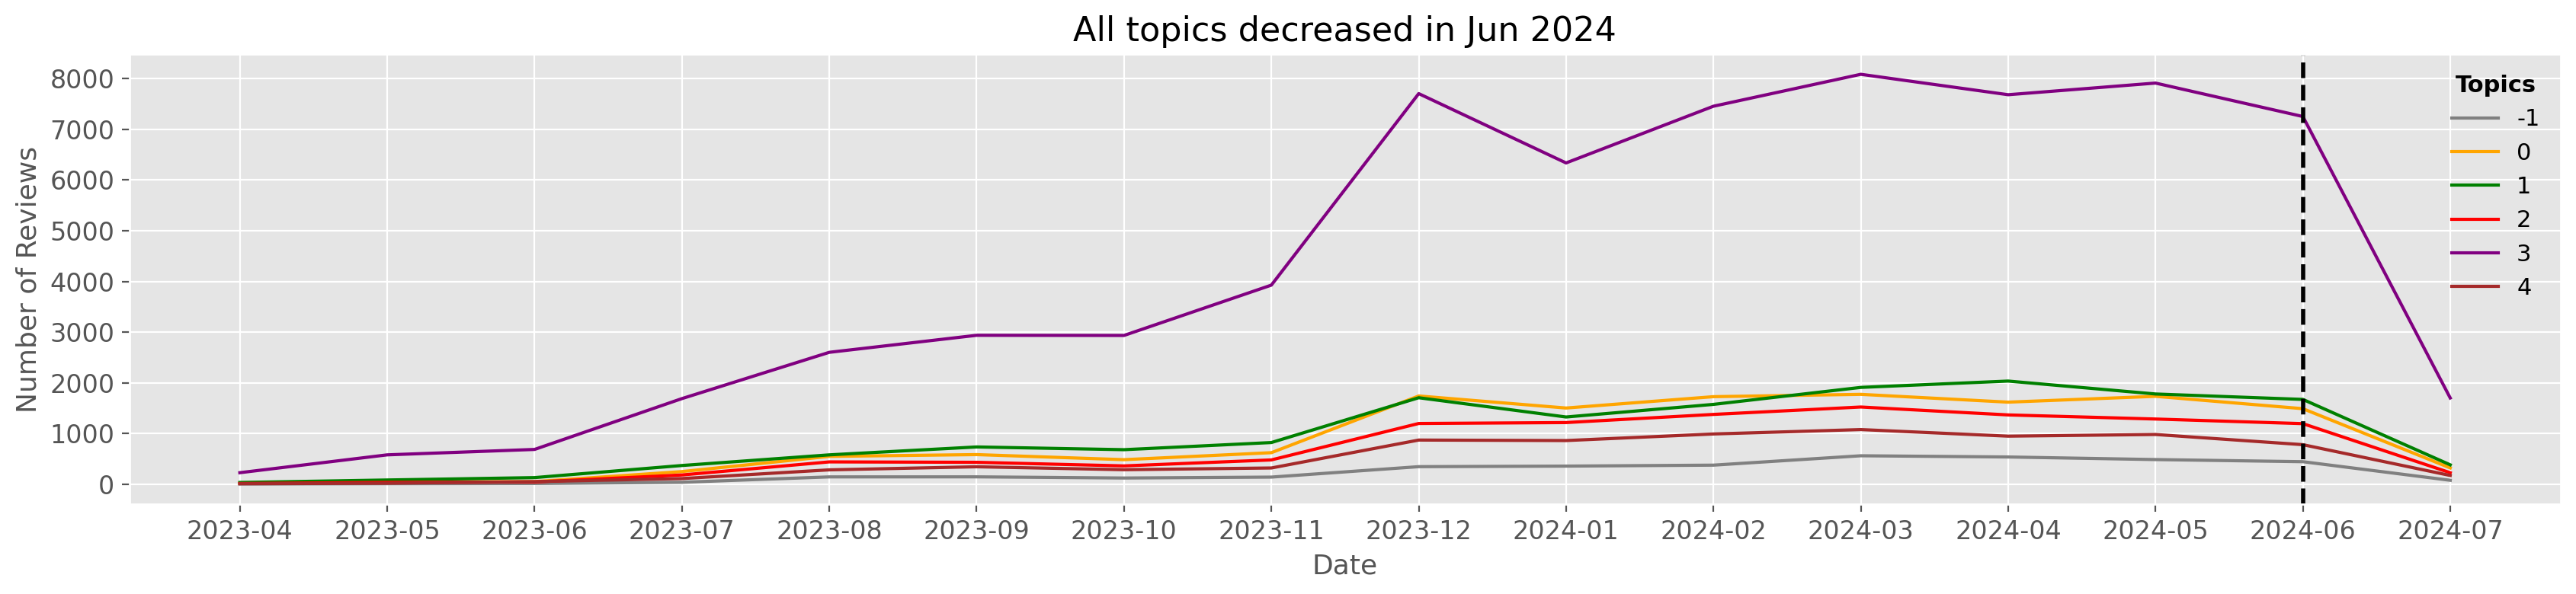

In [233]:
# prepare topic trends data
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df['year_month'] = df['at'].dt.to_period('M').astype(str)
topic_trends = df.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

# plotting trends
plt.figure(figsize=(17, 4), dpi=200)
custom_palette = ['grey', 'orange', 'green', 'red', 'purple', 'brown']
line_styles = ['-', '-', '-', '-', '-', '-']

for idx, topic in enumerate(topic_trends.columns):
    sns.lineplot(data=topic_trends[topic],
                 color=custom_palette[idx % len(custom_palette)],
                 linestyle=line_styles[idx % len(line_styles)],
                 label=topic)

plt.axvline('2024-06', color='k', linestyle='--', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1), title='Topics', facecolor='white',
           frameon=False, title_fontproperties=FontProperties(weight='bold', size=11), fontsize=11)
plt.title('All topics decreased in Jun 2024', size=16)
plt.xlabel('Date', size=13)
plt.ylabel('Number of Reviews', size=13)
plt.xticks(rotation=0, size=12)
plt.yticks(size=12)
plt.grid(True)
plt.tight_layout()
plt.show()

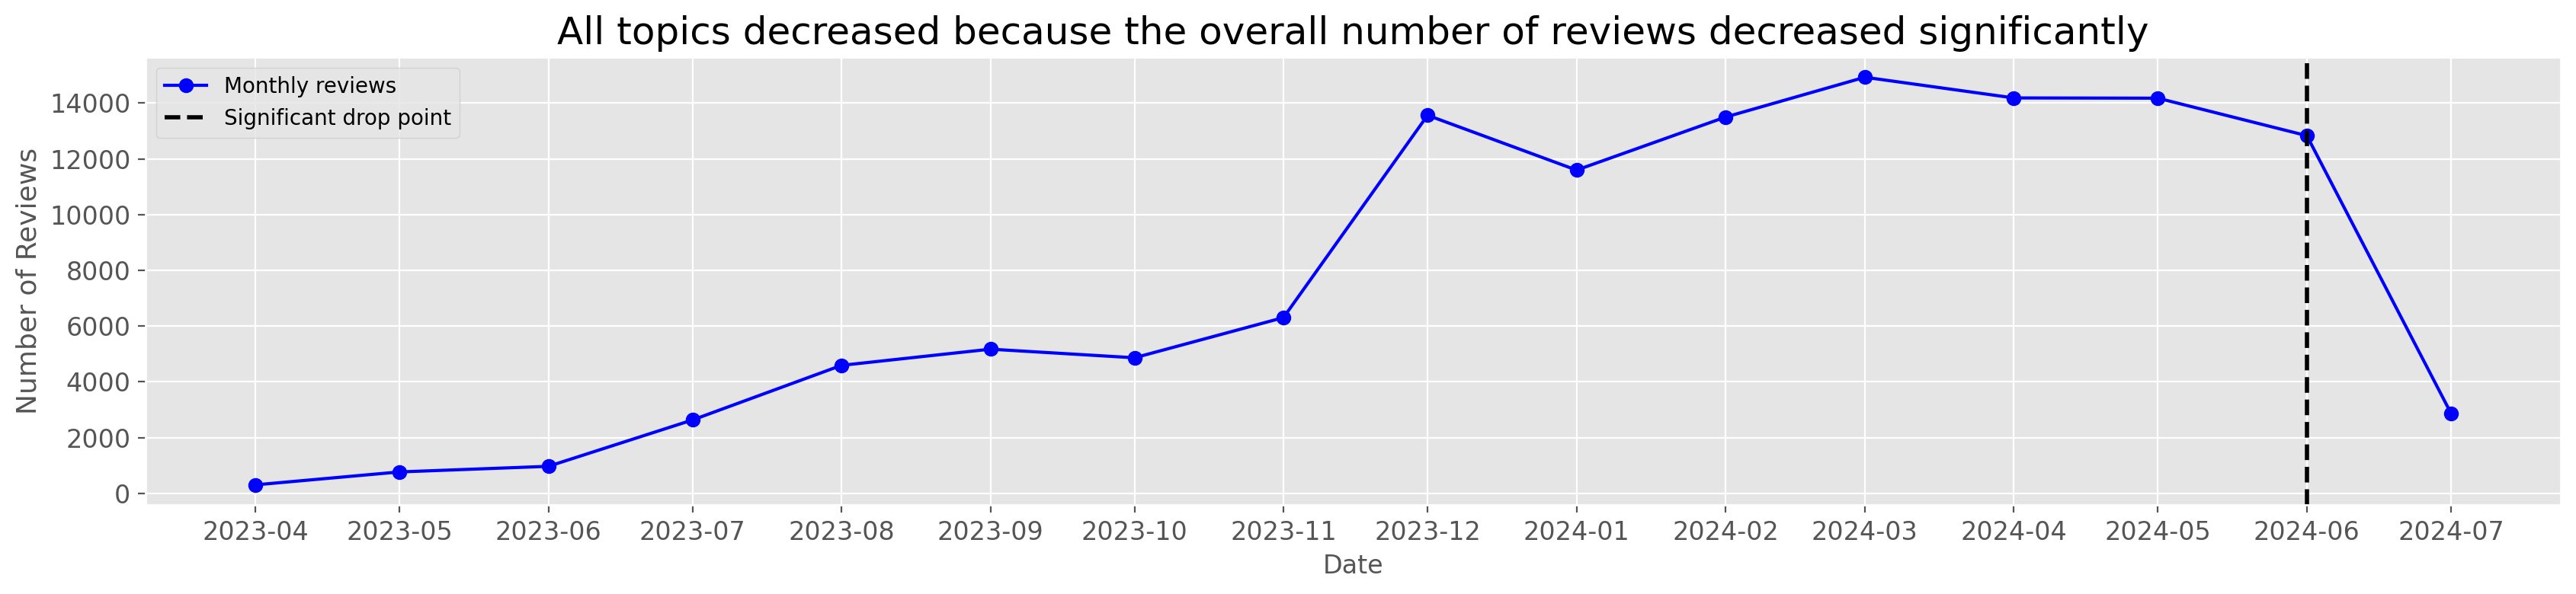

In [244]:
# prepare dataset
df['year_month'] = pd.to_datetime(df['year_month'])
monthly_reviews = df.groupby(df['year_month'].dt.to_period('M')).size()
monthly_reviews_new = monthly_reviews.reset_index(name='count')
monthly_reviews_new['year_month'] = monthly_reviews_new['year_month'].dt.to_timestamp()

# plot number of reviews over time
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(monthly_reviews_new['year_month'], monthly_reviews_new['count'],
         marker='o', color='blue', label='Monthly reviews')

# add vline
plt.axvline(x=pd.Timestamp('2024-06-01'), color='k', linestyle='--',
            linewidth=2, label='Significant drop point')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('All topics decreased because the overall number of reviews decreased significantly',
          size=18)
plt.xlabel('Date', size=12)
plt.ylabel('Number of Reviews', size=13)
plt.xticks(rotation=0, size=12)
plt.yticks(size=12)
plt.grid(True)
plt.legend(title='Legend', frameon=False)
plt.legend()
plt.tight_layout()
plt.show()

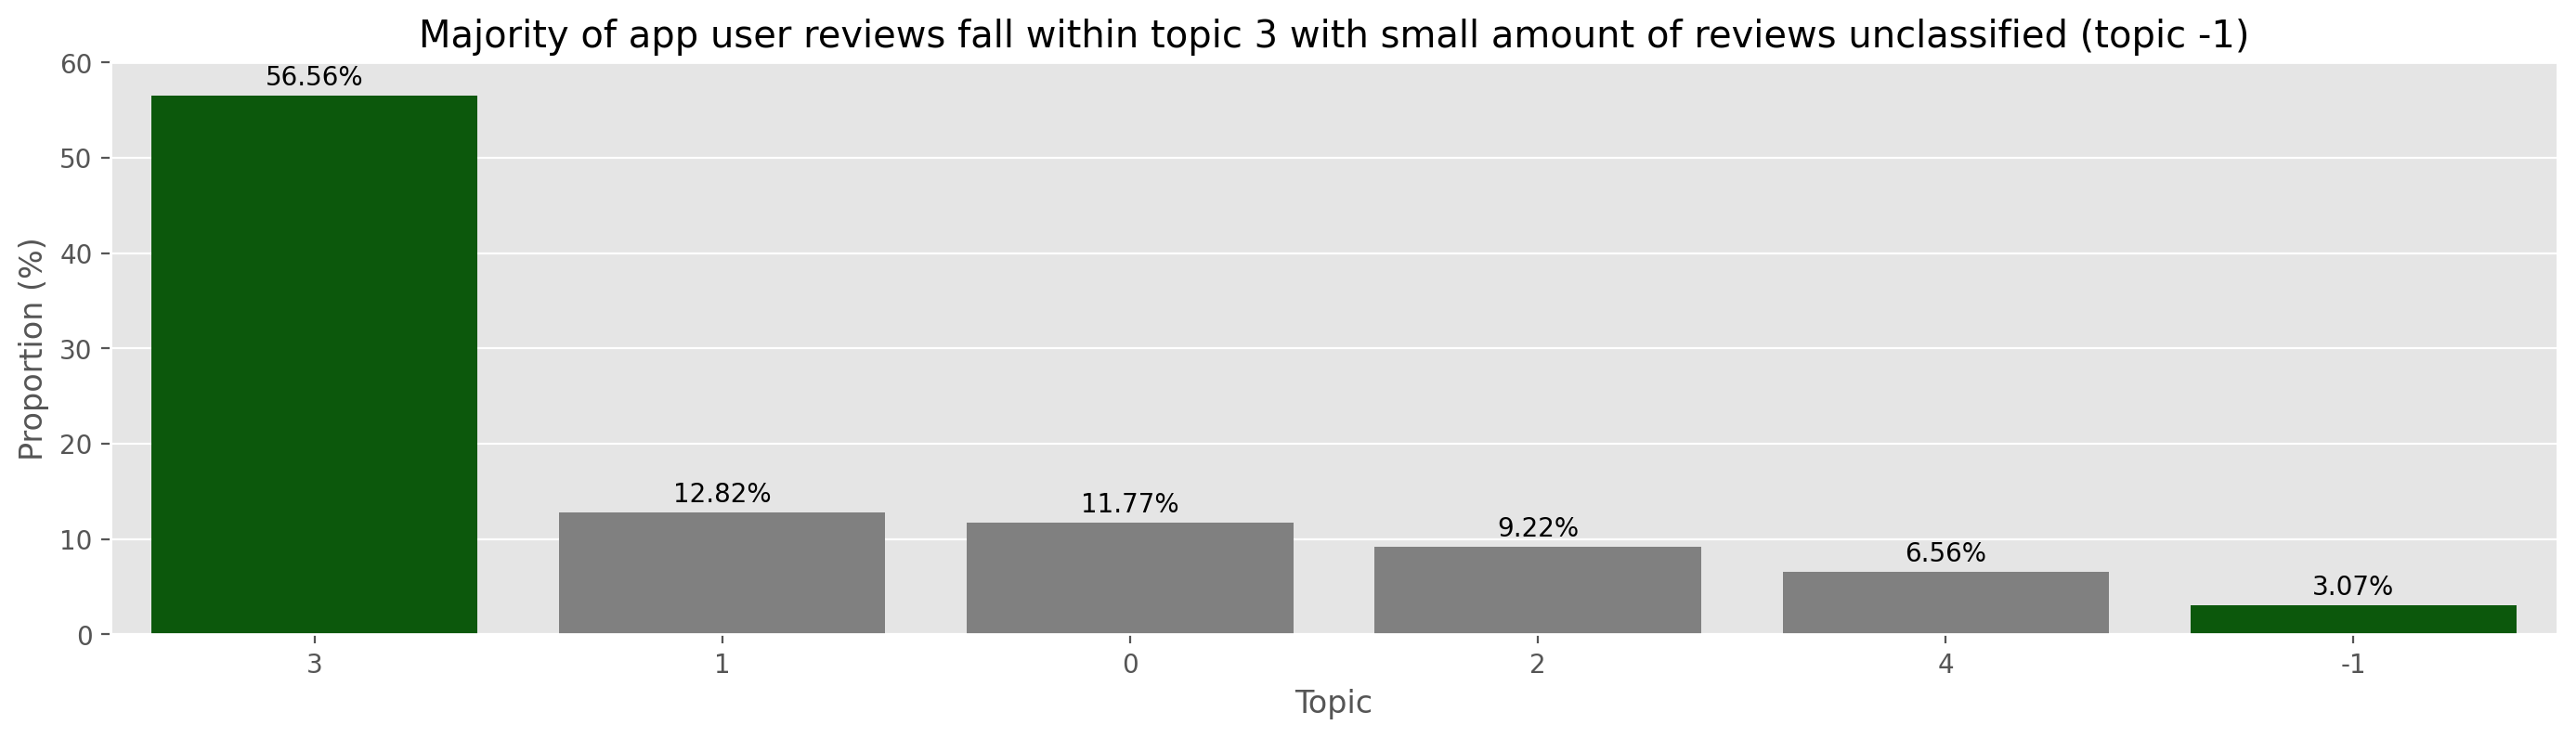

In [236]:
# prepare data for topic proportions
topic_proportion = (df['topic'].value_counts(normalize=True) * 100).reset_index().round(2)
topic_proportion.columns = ['topic', 'proportion']
topic_proportion['topic'] = topic_proportion['topic'].astype(str)
topic_proportion = topic_proportion.sort_values(by='proportion', ascending=False)

# set figure size
plt.figure(figsize=(17, 4), dpi=200)

# highlight topics
highlight_colors = ['darkgreen' if topic in ['3', '-1'] else 'grey' for topic in topic_proportion['topic']]

# make bar chart
sns.barplot(y='proportion', x='topic', data=topic_proportion, palette=highlight_colors)
for index, row in topic_proportion.iterrows():
    plt.text(row.name, row['proportion'] + 0.5, f'{row["proportion"]:.2f}%',
             ha='center', va='bottom', fontsize=10)
plt.yticks(range(0, 70, 10))
plt.title('Majority of app user reviews fall within topic 3 with small amount of reviews unclassified (topic -1)')
plt.xlabel('Topic')
plt.ylabel('Proportion (%)')
plt.show()

#### **5.6.5 Visualize Topic Distribution for Documents**

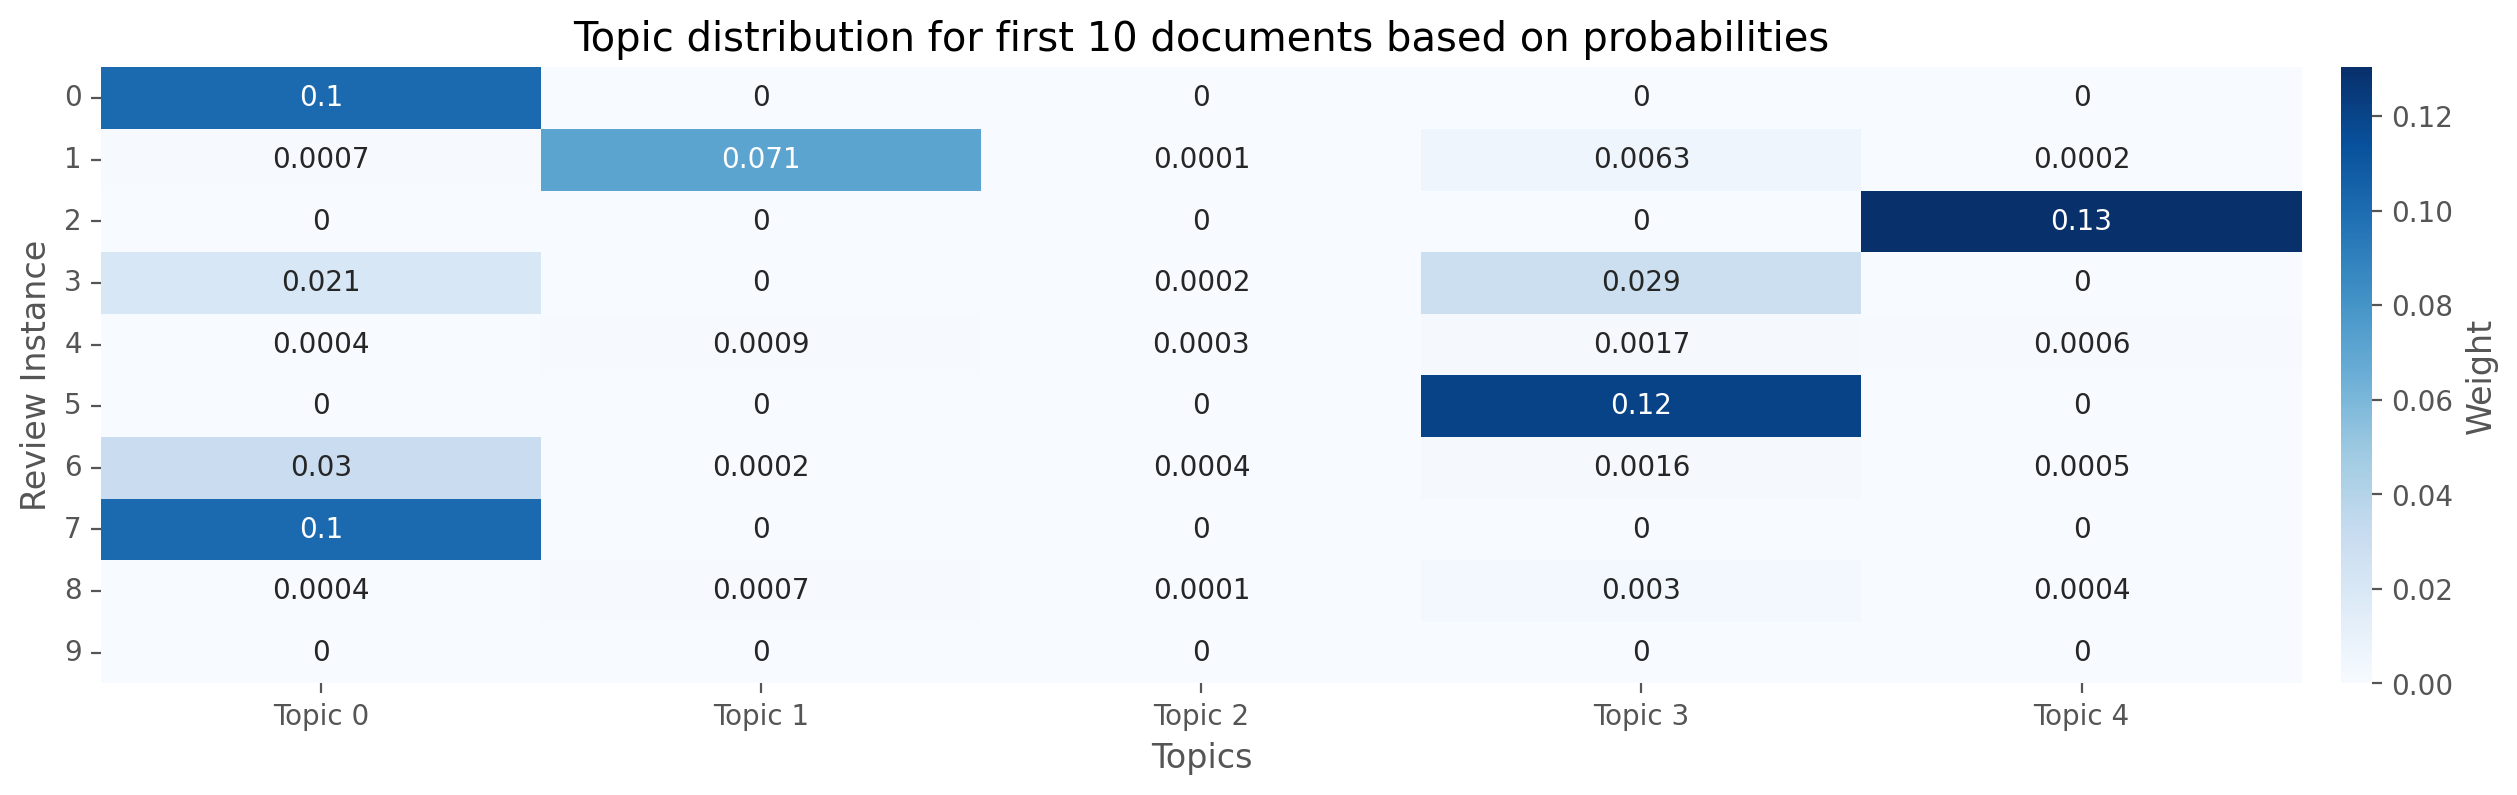

In [237]:
# prepare topic distribution data for each document
topic_distribution = tuned_nmf_model.transform(tfidf_matrix)

# create df for topic distribution
topic_df = pd.DataFrame(topic_distribution,
                        columns=[f'Topic {i}' for i in range(tuned_nmf_model.n_components)]).round(4)

# visualize topic distribution (10 instance only)
plt.figure(figsize=(17, 4), dpi=200)
sns.heatmap(topic_df.iloc[:10], cmap='Blues', annot=True, cbar_kws={'label': 'Weight', 'pad': 0.015})
plt.title('Topic distribution for first 10 documents based on probabilities')
plt.ylabel('Review Instance')
plt.xlabel('Topics')
plt.yticks(rotation=0)
plt.show()

#### **5.6.6 Topic Overlap**

**Shared terms**

In [238]:
# get feature names (aka words)
feature_names = vectorizer.get_feature_names_out()

# function to get top words per topic
def get_top_words(model, feature_names, topic_idx, n_top_words):
    topic = model.components_[topic_idx]
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return set(top_words)

# get top words for all topics and store in a list of sets
n_top_words = 10
topic_top_words = [get_top_words(nmf_model, feature_names, topic_idx, n_top_words)
                   for topic_idx in range(nmf_model.n_components_)]

# find intersection (common words) across all topics
common_words = set.intersection(*topic_top_words)
print(f"Shared words across all topics: {common_words}")

Shared words across all topics: {'membantu', 'gopay', 'aplikasi', 'bagus', 'mantap', 'ok', 'banget', 'mudah'}


**Topic distribution**

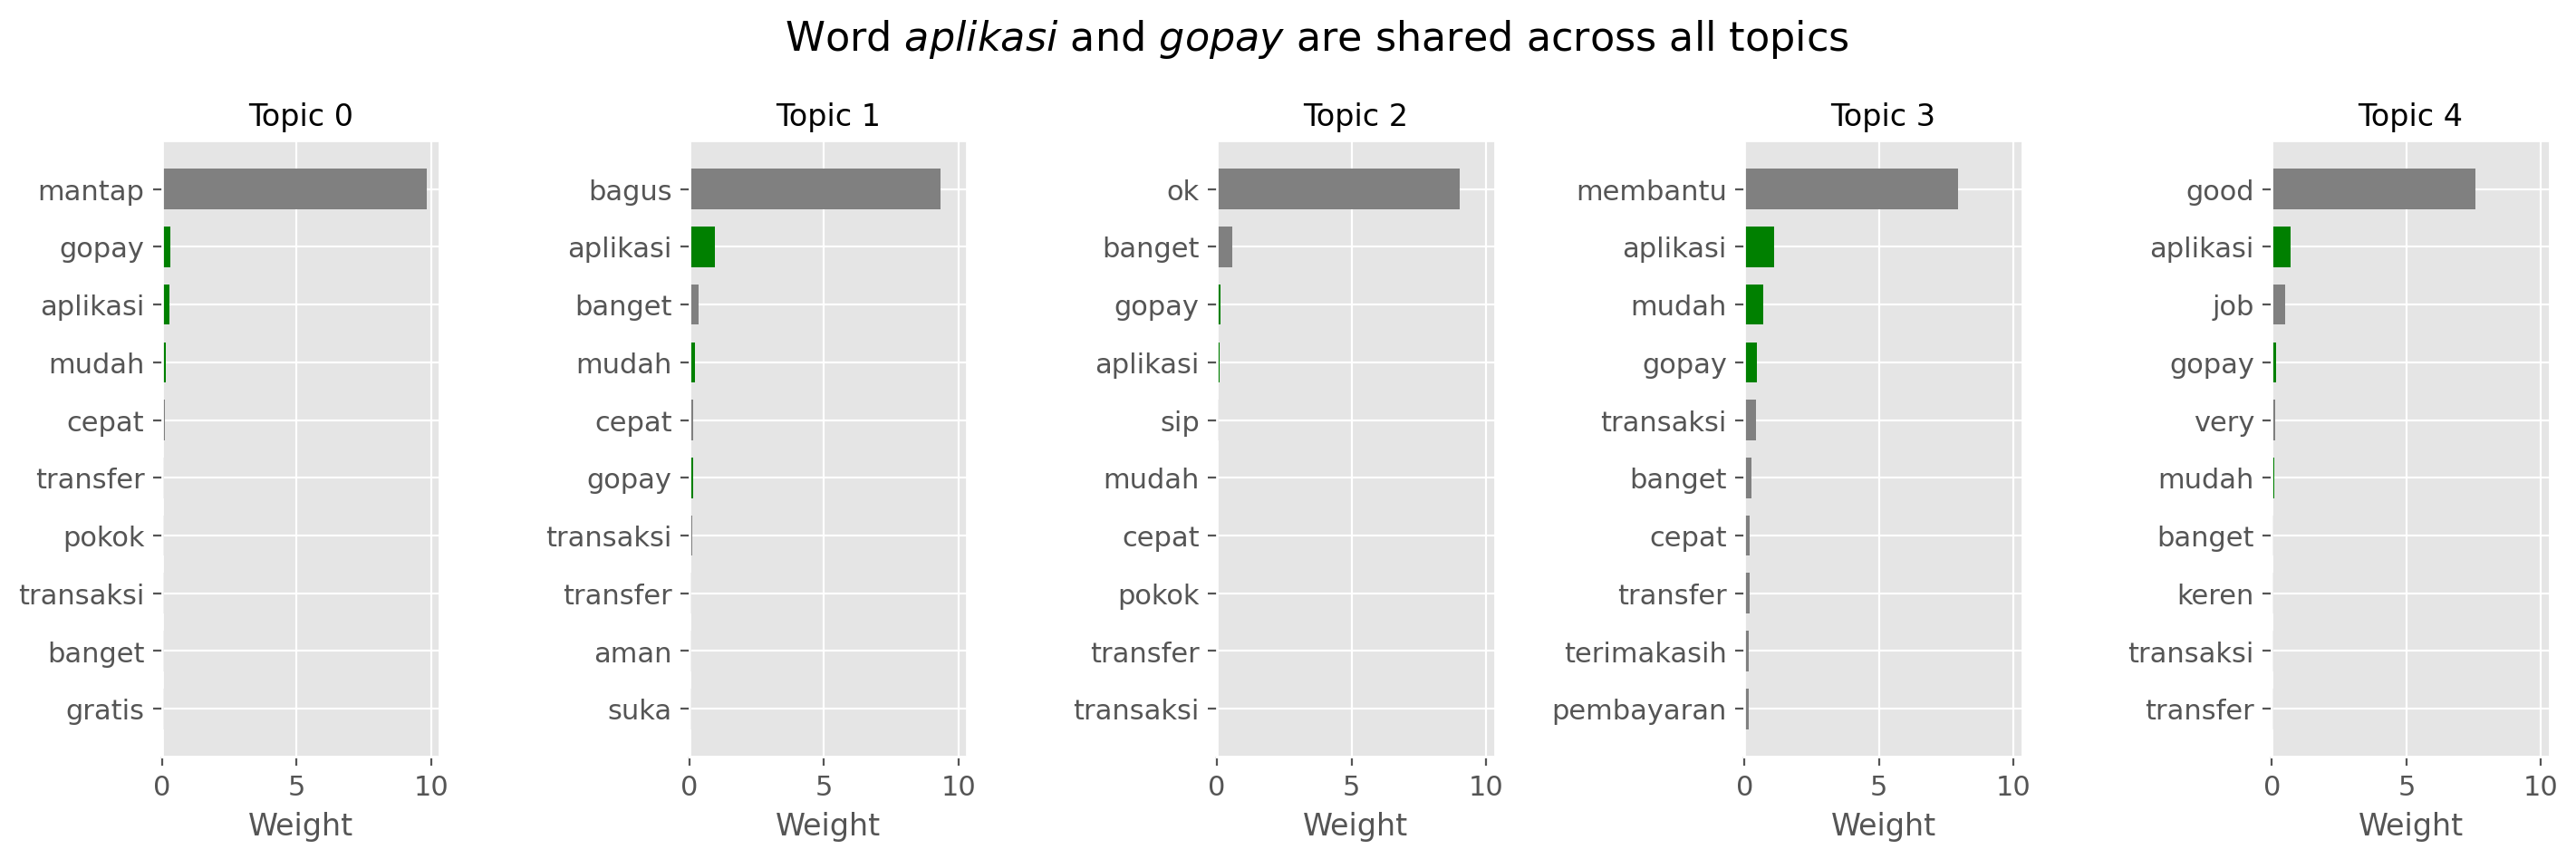

In [239]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, optimal_num_topics, figsize=(17, 4), dpi=200, sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        # get top feature indices
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        # for highlight
        colors = ['grey' if word not in ['mudah', 'aplikasi', 'gopay'] else 'green' for word in top_features]

        # plotting
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=colors)
        ax.set_title(f'Topic {topic_idx}', fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.set_xlabel('Weight', size=12)
        ax.tick_params(axis='both', which='major', labelsize=11)

    plt.suptitle(title, fontsize=16, y=1.07)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# apply function
plot_top_words(tuned_nmf_model, vectorizer.get_feature_names_out(), 10,
               'Word $aplikasi$ and $gopay$ are shared across all topics')

In [240]:
num_words = 20  # n of top words per topic
topics_data = []
topic_words = []

# extract top words and their weights
for idx, topic in enumerate(tuned_nmf_model.components_):
    top_words_idx = topic.argsort()[::-1][:num_words]  # get indices of top words
    for i in top_words_idx:
        word = vectorizer.get_feature_names_out()[i]   # get word using index
        weight = topic[i]
        topics_data.append([f'Topic {idx}', word, weight])
        if word not in topic_words:
            topic_words.append(word)

# convert into df
termite_df = pd.DataFrame(topics_data, columns=['Topic', 'Word', 'Weight'])
termite_df.sort_values(by='Weight', ascending=False).head()

,Topic,Word,Weight
0,Topic 0,mantap,9.826408
20,Topic 1,bagus,9.339516
40,Topic 2,ok,9.014610
60,Topic 3,membantu,7.940821
80,Topic 4,good,7.565696


**Termite plot**

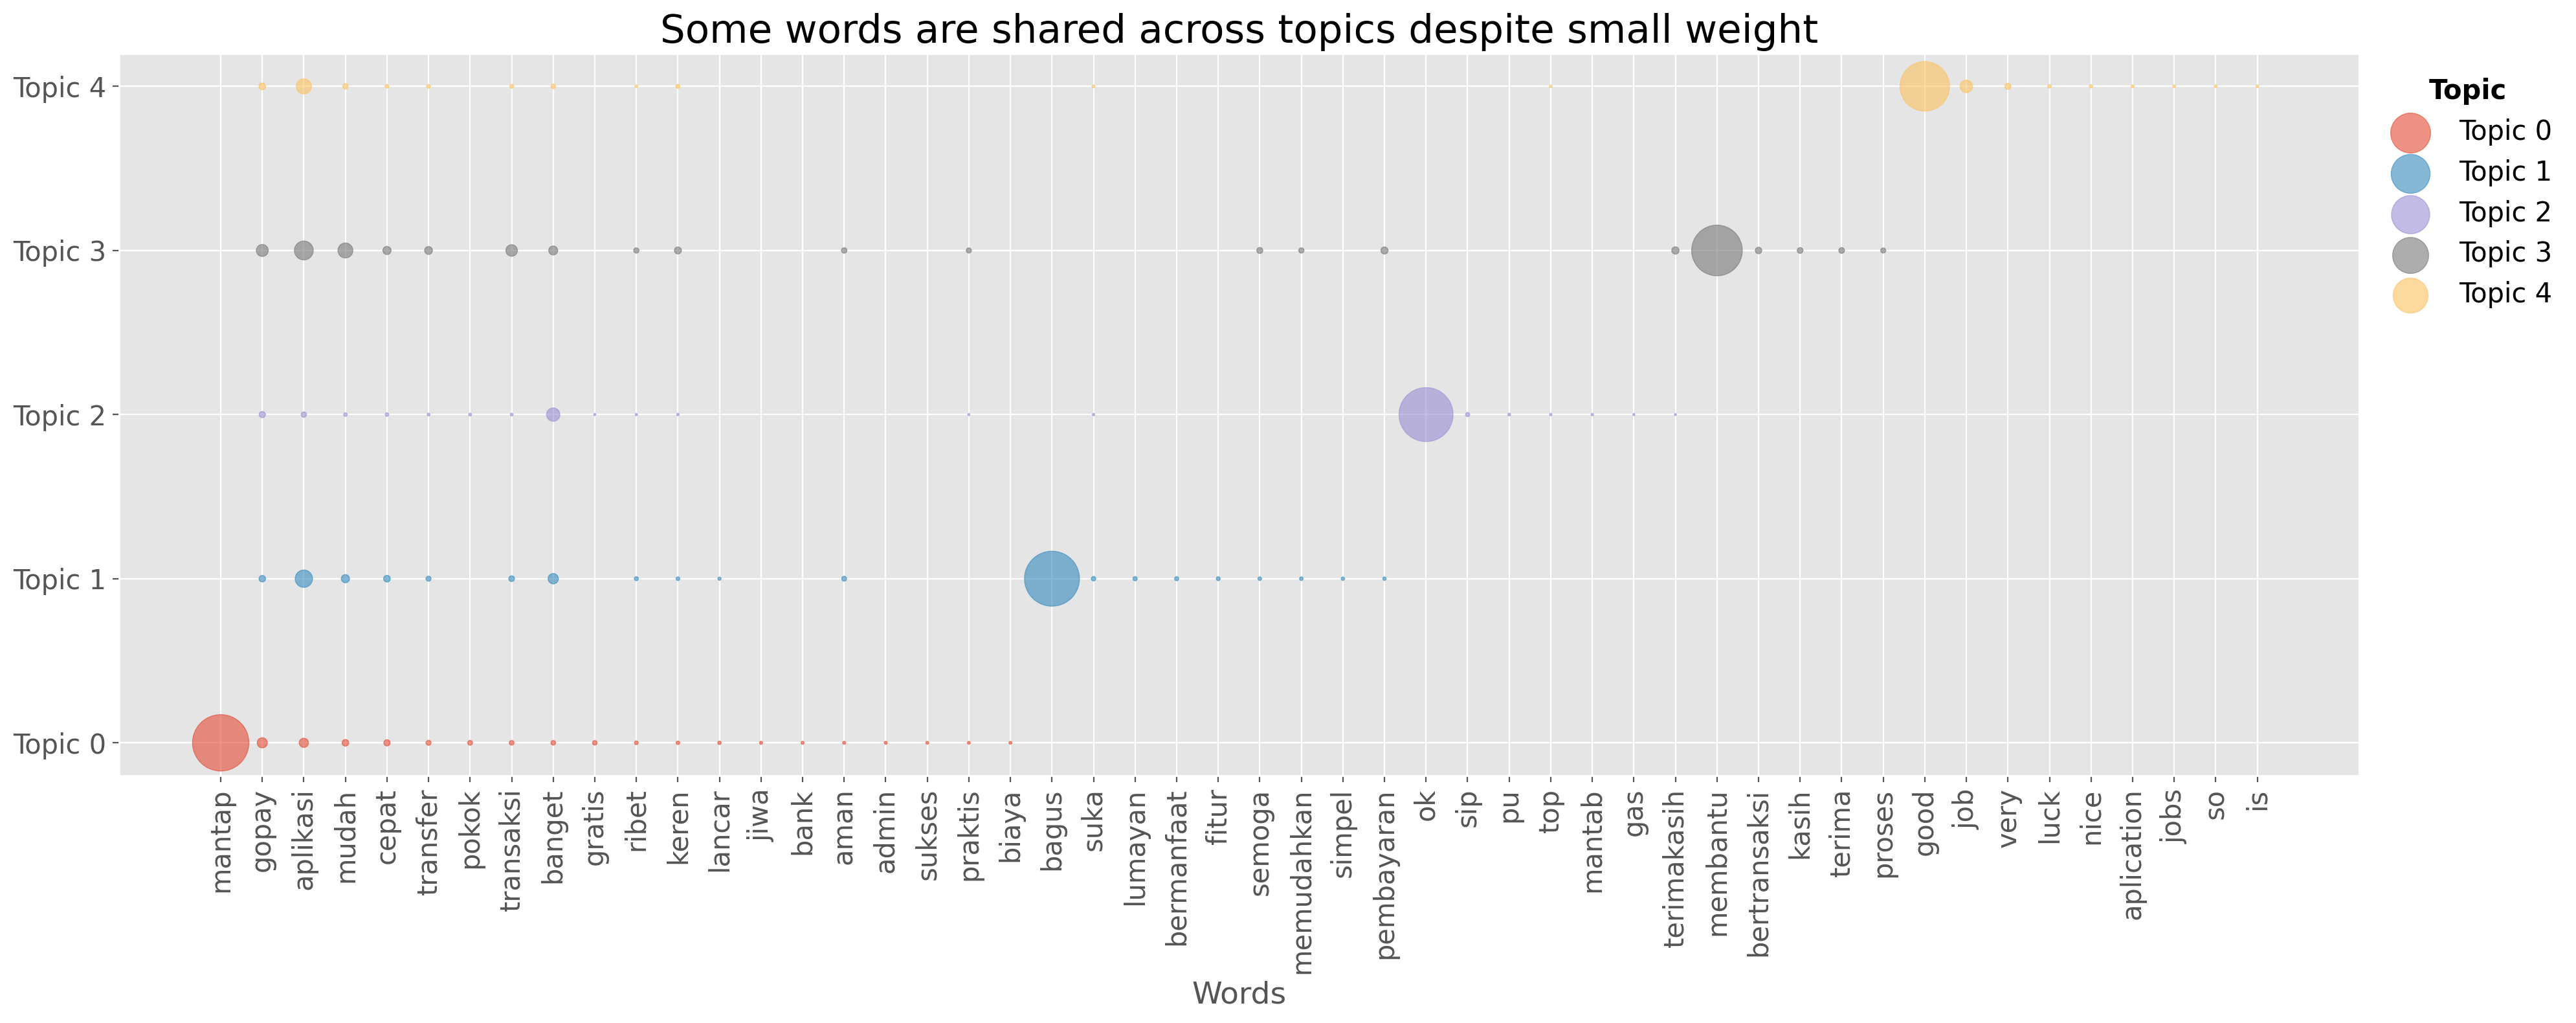

In [241]:
# visualize termite plot
plt.figure(figsize=(20, 8), dpi=200)
for topic in termite_df['Topic'].unique():
    topic_data = termite_df[termite_df['Topic'] == topic]
    plt.scatter(topic_data['Word'], topic_data['Topic'],
                s=topic_data['Weight']*100, alpha=0.6, label=topic)

plt.title('Some words are shared across topics despite small weight', size=22)
plt.xlabel('Words', size=17)
plt.ylabel(None)
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)

# add legend
plt.legend(bbox_to_anchor=(1, 1), title='Topic', facecolor='white', frameon=False,
           title_fontproperties=FontProperties(weight='bold', size=15), fontsize=15)

plt.tight_layout()
plt.show()

**Cosine similarity**

In [245]:
# get word-topic matrix from NMF model
word_topic_matrix = tuned_nmf_model.components_

# calculate cosine similarity between topics
similarity_matrix = cosine_similarity(word_topic_matrix)

# convert similarity matrix into df
similarity_df = pd.DataFrame(similarity_matrix,
                             columns=[f'Topic {i}' for i in range(similarity_matrix.shape[1])],
                             index=[f'Topic {i}' for i in range(similarity_matrix.shape[0])])

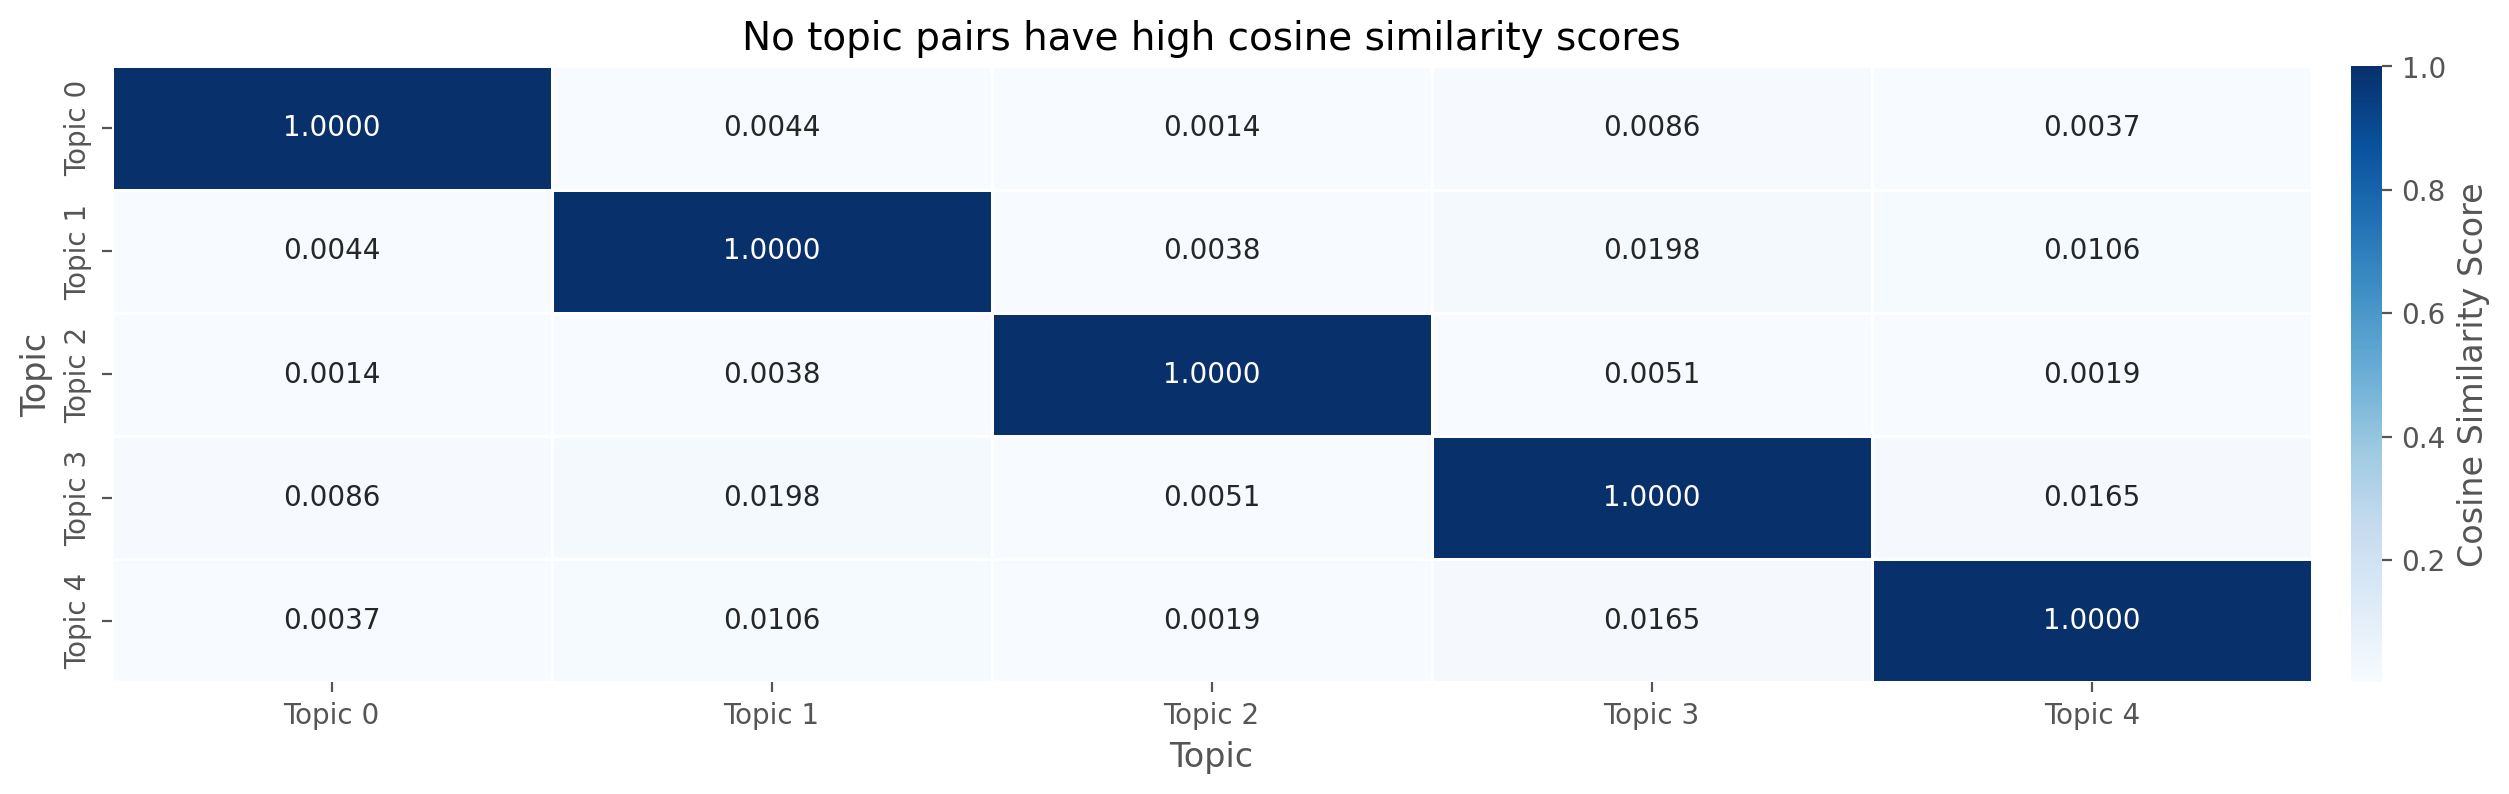

In [243]:
plt.figure(figsize=(17, 4), dpi=200)

# plot heatmap
sns.heatmap(similarity_df, annot=True, cmap='Blues', linewidths=0.5, fmt=".4f",
            cbar_kws={'label': 'Cosine Similarity Score', 'pad': 0.015})
plt.title('No topic pairs have high cosine similarity scores', fontsize=14)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.show()